## Implementing K-Means Clustering

In [1]:
from fastkaggle import get_dataset
from pathlib import Path
from fastai.tabular.all import *

## Dataset

In [2]:
path = Path('data/dbscan')
dataset = 'vjchoudhary7/customer-segmentation-tutorial-in-python'
if not path.exists():
    data = get_dataset(path, dataset, unzip=True)
df = pd.read_csv(path/'Mall_Customers.csv', low_memory=False)

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Plotting the Target Datapoints

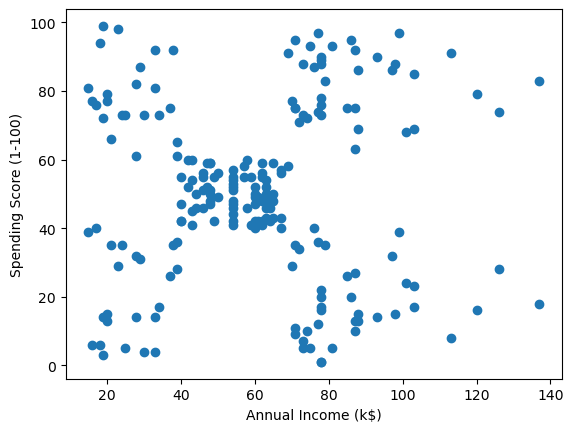

In [4]:
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
plt.scatter(x,y)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

Convert the pandas dataframe to a pytorch tensor to utilize the GPU

In [5]:
x_y_tens = torch.from_numpy(df.to_numpy()[:,3:].astype(float)).to("cuda")

## Picking *k* Centroids

In [6]:
k = 5

Next, we randomly pick those *k* random points as the initial cluster centroids

In [7]:
sample_idxs = torch.randperm(x_y_tens.shape[0])[:5]
centroids = x_y_tens[sample_idxs]
centroids

tensor([[40., 42.],
        [25., 73.],
        [58., 46.],
        [43., 45.],
        [77., 74.]], device='cuda:0', dtype=torch.float64)

In [8]:
og_centroids = centroids.clone()

In [9]:
def np_detach(tens):
    return tens.detach().cpu().numpy()

Plotting the initial data with centroids marked

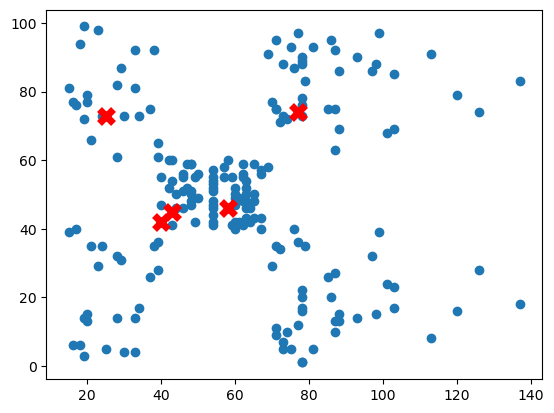

In [10]:
x = np_detach(x_y_tens)[:,0]
y = np_detach(x_y_tens)[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)
for cen in centroids:
    ax.plot(np_detach(cen)[0], np_detach(cen)[1], markersize=10, marker="x", color='r', mew=5)
    

## Calculating the Distance with Frobenius Norm

In [11]:
def euclidean_dist(a, b):
    return torch.norm(a-b, dim=-1)

## Calculate distance to centroids and assign

Now we calculate the distance of each data point to each centroid

In [12]:
distances = euclidean_dist(x_y_tens.unsqueeze(1), centroids.unsqueeze(0))

Then, assign each point to its nearest cluster

In [13]:
cluster_assignments = torch.argmin(distances, dim=1)

In [14]:
og_cluster_assignments = cluster_assignments.clone()

Plotting our initial cluster assignments:

In [15]:
def plot_clusters(data, centroids, assignments):
    plt.clf()
    data, centroids, assignments = np_detach(data), np_detach(centroids), np_detach(assignments)
    plt.scatter(data[:,0], data[:,1], c=assignments, s=30)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='red', s=60)

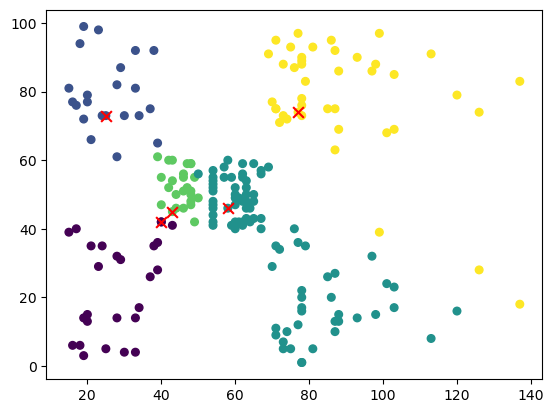

In [16]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

We'll need to iterate several times over these steps, so we'll start aggregating them into functions

In [17]:
def assign_to_nearest_centroid(data, centroids):
    distances = euclidean_dist(data.unsqueeze(1), centroids.unsqueeze(0))
    cluster_assignments = torch.argmin(distances, dim=1)
    return cluster_assignments

Now that we've assigned all datapoints to clusters, we have to update the centroids. This is done by taking the mean of all data points assigned to a cluster, resulting in a new centroid

In [18]:
def update_centroids(data, cluster_assignments, centroids): 
    new_centroids = torch.zeros_like(centroids)
    for i in range(centroids.shape[0]):
        assigned_points = data[cluster_assignments == i]
        if len(assigned_points) > 0:
            new_centroids[i] = torch.mean(assigned_points, dim=0)
    return new_centroids

In [19]:
new_centroids = update_centroids(x_y_tens, cluster_assignments, centroids)

Plotting our centroid update:

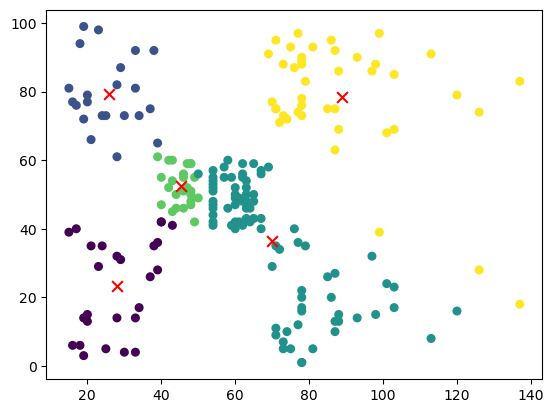

In [20]:
plot_clusters(x_y_tens, new_centroids, cluster_assignments)

## Repeat

Now we'll run through the assignment/update loop several times and hopefully converge in the process

In [21]:
def k_means(data, centroids, iterations=10):
    for i in range(iterations):
        cluster_assignments = assign_to_nearest_centroid(data, centroids)
        new_centroids = update_centroids(data, cluster_assignments, centroids)
    cluster_assignments = assign_to_nearest_centroid(data, centroids)
    return cluster_assignments, new_centroids

In [22]:
cluster_assignments, centroids = k_means(x_y_tens, centroids)

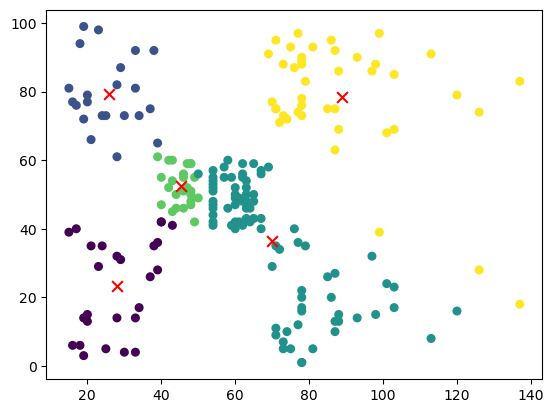

In [23]:
plot_clusters(x_y_tens, centroids, cluster_assignments)

## Animation

Finally, we'll use our original centroids and cluster assignments to see it in action

In [24]:
centroids = og_centroids
cluster_assignments = og_cluster_assignments

In [25]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

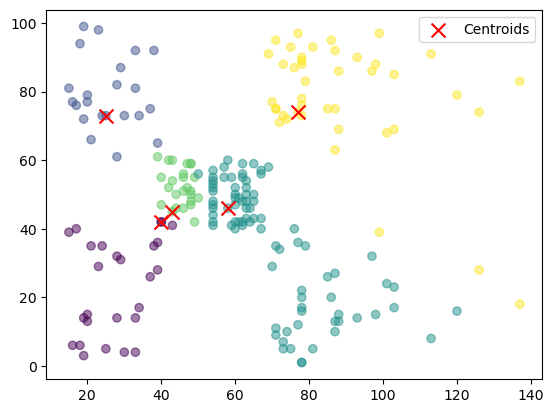

In [26]:
fig, ax = plt.subplots()

# Set up the initial plot
scatter = ax.scatter(np_detach(x_y_tens[:, 0]), np_detach(x_y_tens[:, 1]), c=np_detach(cluster_assignments), cmap='viridis', alpha=0.5)
centroid_plot = ax.scatter(np_detach(centroids[:, 0]), np_detach(centroids[:, 1]), c='red', marker='x', s=100, label='Centroids')
ax.legend()

In [27]:
def init():
    return scatter, centroid_plot

In [28]:
def update(frame):
    global x_y_tens, centroids, cluster_assignments
    
    # Step 1: Assign x_y_tens points to the nearest centroid
    cluster_assignments = assign_to_nearest_centroid(x_y_tens, centroids)

    # Step 2: Update centroids
    updated_centroids = update_centroids(x_y_tens, cluster_assignments, centroids)

    # Update plot
    scatter.set_array(np_detach(cluster_assignments))
    centroid_plot.set_offsets(np_detach(updated_centroids))
    centroids = updated_centroids
    
    return scatter, centroid_plot

In [29]:
ani = FuncAnimation(fig, update, frames=10, init_func=init, blit=True, interval=200, repeat=False)
plt.close()
HTML(ani.to_jshtml())